In [115]:
import pandas as pd
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import datetime

In [116]:
records = pd.read_csv('btrecords.csv')
sites = pd.read_csv('btsites.csv')

In [117]:
#Clean sites data
sites = sites[sites['enabled'] == True]
sites = sites[['id', 'longitude', 'latitude']]
sites = sites.drop_duplicates(subset='id', keep="first")

In [118]:
#Calculate time in range for probes, clean data
records.logtime = pd.to_datetime(records.logtime)
records.firstseenat = pd.to_datetime(records.firstseenat)
records["time_in_range"] = records.logtime - records.firstseenat
records = records.drop(['logtime'], axis = 1)
records = records.drop_duplicates()

In [119]:
#Merge records and sites by site id
data = records.merge(sites,how='inner', left_on='siteid',right_on='id')

In [120]:
#Summary counts

print('Number of unique site beacons(siteid):',data['siteid'].nunique())
print('Number of unique cars (probeid):',data['probeid'].nunique())

Number of unique site beacons(siteid): 1053
Number of unique cars (probeid): 3557996


<AxesSubplot:>

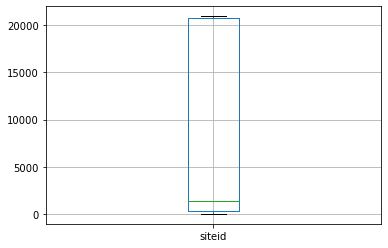

In [121]:
#Boxplot of siteids if that is interesting
data.boxplot(column=['siteid'])

<AxesSubplot:>

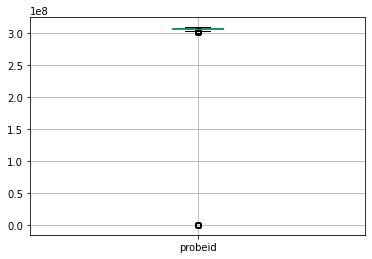

In [122]:
#Boxplot of probeids if that is interesting
data.boxplot(column=['probeid'])

In [123]:
#Count number of probes detected at each site
sitecounts = data.groupby(['siteid']).size().reset_index(name='siteCount')
graph1 = sites.merge(sitecounts,how='left', left_on='id',right_on='siteid')
graph1 = graph1.drop(['siteid'], axis = 1)
#Drop sites where no probes detected
graph1 = graph1[graph1['siteCount'].notna()]

graph1

,id,longitude,latitude,siteCount
0,20966,138.652939,-34.973263,14504.0
2,1295,138.621399,-35.349491,2831.0
3,2,138.523289,-34.986657,4883.0
4,3,138.548194,-34.872397,5636.0
5,4,138.483990,-34.838911,6438.0
...,...,...,...,...
1101,20960,138.571716,-34.874863,94038.0
1102,20961,138.570862,-34.871132,7914.0
1103,20962,138.455414,-34.929844,22.0
1104,20963,138.571915,-34.880527,38881.0


In [124]:
graph1.siteCount.describe()

count      1053.000000
mean      12178.562203
std       19007.799382
min          22.000000
25%        4772.000000
50%        7147.000000
75%       10413.000000
max      195607.000000
Name: siteCount, dtype: float64

In [125]:
#Map of all the siteids with avalible cords and color coded based on how often cars passed them

m_1 = folium.Map(location=[ -34.921230,138.599503], tiles='cartodbpositron', zoom_start=10)

def color_producer(val):
    if val <= 4772:
        return 'lightpink'
    elif val > 4772 and val <=7147:
        return 'pink'
    elif val > 7147 and val <=10413:
        return 'red'
    else:
        return 'darkred'

for i in range(0,len(graph1)):
    Circle(
        location=[graph1.iloc[i]['latitude'], graph1.iloc[i]['longitude']],
        radius=20,
        color=color_producer(graph1.iloc[i]['siteCount'])).add_to(m_1)
m_1

# Step 1-2

### 1. Remove entries of cars that were only detected once
### 2. Group rows by cars and then sort by time

In [126]:
#Filter out probes that were detected only once, and therefore cannot form a trip
data1 = data[data.groupby('probeid').probeid.transform('count') > 1]
data1 = data1.sort_values(["probeid", "firstseenat"], ascending = (False, True))
#data1 = data1.head(50000) #use this if you want to test code so things run faster

In [127]:
#10158595 total rows
#leading to only 892,565 unique cars left that didn't just pass one site and then was never detected again
data1

,probeid,siteid,firstseenat,time_in_range,id,longitude,latitude
9042397,308641971,20888,2021-09-01 23:59:44+09:30,0 days 00:00:17,20888,138.557648,-35.025688
3270269,308641971,20850,2021-09-01 23:59:51+09:30,0 days 00:00:00,20850,138.555206,-35.030403
5190661,308641906,1209,2021-09-01 23:59:33+09:30,0 days 00:00:01,1209,138.645875,-34.810556
4905992,308641906,275,2021-09-01 23:59:54+09:30,0 days 00:00:17,275,138.649273,-34.806755
1147146,308641904,380,2021-09-01 23:59:30+09:30,0 days 00:00:00,380,140.785924,-37.832460
...,...,...,...,...,...,...,...
12795390,1347,1338,2021-09-01 23:49:16+09:30,0 days 00:00:00,1338,138.639649,-34.886198
3038266,1347,5057,2021-09-01 23:52:19+09:30,0 days 00:00:50,5057,138.661583,-34.868862
5047979,1347,489,2021-09-01 23:53:25+09:30,0 days 00:00:00,489,138.663034,-34.867069
12778390,1347,5056,2021-09-01 23:57:44+09:30,0 days 00:01:00,5056,138.694870,-34.831989


In [128]:
print('Number of unique cars before (probeid):',data['probeid'].nunique())
print('Number of unique cars after (probeid):',data1['probeid'].nunique())

Number of unique cars before (probeid): 3557996
Number of unique cars after (probeid): 892565


In [129]:
data1.drop('id', axis=1, inplace=True) #remove one of the id columns cause they are same

# Step 2

### 1. Calculate the time between each consequative siteids 
### 2. Create a new column to indiciate consequative trips

In [130]:
'''
data1['firstseenat']=pd.to_datetime(data1['firstseenat'])
def find_ranges(firstProbe,secondProbe,a,b):
    if firstProbe == secondProbe:
        return a-b
    else:
        return -69

data1['time_between_site'] = data1.apply(lambda row : find_ranges(row['probeid'],row['probeid'].shift(-1),row['firstseenat'].shift(-1),row['firstseenat']), axis = 1)    
'''
data1['time_between_site'] =  data1['firstseenat'].shift(-1) - data1['firstseenat']
def to_seconds(a):
    return a.total_seconds()

data1['time_between_site'] = data1.apply(lambda row : to_seconds(row['time_between_site']), axis = 1)

In [131]:
#As shift(-1) does not work to find the next case allowing us to calculate the values directly given condition
#We will just set all negative values to NAN manually as that indicates that the trip end and different car starts
#and it is not included in calculations.

In [132]:
data1['temp'] = data1.siteid.shift(-1)

In [133]:
data2=data1
data2 = data2[:-1]
data2

,probeid,siteid,firstseenat,time_in_range,longitude,latitude,time_between_site,temp
9042397,308641971,20888,2021-09-01 23:59:44+09:30,0 days 00:00:17,138.557648,-35.025688,7.0,20850.0
3270269,308641971,20850,2021-09-01 23:59:51+09:30,0 days 00:00:00,138.555206,-35.030403,-18.0,1209.0
5190661,308641906,1209,2021-09-01 23:59:33+09:30,0 days 00:00:01,138.645875,-34.810556,21.0,275.0
4905992,308641906,275,2021-09-01 23:59:54+09:30,0 days 00:00:17,138.649273,-34.806755,-24.0,380.0
1147146,308641904,380,2021-09-01 23:59:30+09:30,0 days 00:00:00,140.785924,-37.832460,15.0,389.0
...,...,...,...,...,...,...,...,...
771724,1347,127,2021-09-01 23:44:58+09:30,0 days 00:00:00,138.612573,-34.908819,258.0,1338.0
12795390,1347,1338,2021-09-01 23:49:16+09:30,0 days 00:00:00,138.639649,-34.886198,183.0,5057.0
3038266,1347,5057,2021-09-01 23:52:19+09:30,0 days 00:00:50,138.661583,-34.868862,66.0,489.0
5047979,1347,489,2021-09-01 23:53:25+09:30,0 days 00:00:00,138.663034,-34.867069,259.0,5056.0


In [134]:
data2['temp']=data2['temp'].astype(int)
data2['siteid'] = data2['siteid'].astype(str)
data2['temp'] = data2['temp'].astype(str)

<ipython-input-134-5e3dcfc4f7b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['temp']=data2['temp'].astype(int)
<ipython-input-134-5e3dcfc4f7b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['siteid'] = data2['siteid'].astype(str)
<ipython-input-134-5e3dcfc4f7b5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [135]:
data2

,probeid,siteid,firstseenat,time_in_range,longitude,latitude,time_between_site,temp
9042397,308641971,20888,2021-09-01 23:59:44+09:30,0 days 00:00:17,138.557648,-35.025688,7.0,20850
3270269,308641971,20850,2021-09-01 23:59:51+09:30,0 days 00:00:00,138.555206,-35.030403,-18.0,1209
5190661,308641906,1209,2021-09-01 23:59:33+09:30,0 days 00:00:01,138.645875,-34.810556,21.0,275
4905992,308641906,275,2021-09-01 23:59:54+09:30,0 days 00:00:17,138.649273,-34.806755,-24.0,380
1147146,308641904,380,2021-09-01 23:59:30+09:30,0 days 00:00:00,140.785924,-37.832460,15.0,389
...,...,...,...,...,...,...,...,...
771724,1347,127,2021-09-01 23:44:58+09:30,0 days 00:00:00,138.612573,-34.908819,258.0,1338
12795390,1347,1338,2021-09-01 23:49:16+09:30,0 days 00:00:00,138.639649,-34.886198,183.0,5057
3038266,1347,5057,2021-09-01 23:52:19+09:30,0 days 00:00:50,138.661583,-34.868862,66.0,489
5047979,1347,489,2021-09-01 23:53:25+09:30,0 days 00:00:00,138.663034,-34.867069,259.0,5056


In [136]:
data2['2_routes'] = data2[['siteid', 'temp']].agg(' -> '.join, axis=1)

<ipython-input-136-e916d8317d41>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['2_routes'] = data2[['siteid', 'temp']].agg(' -> '.join, axis=1)


In [137]:
data2

,probeid,siteid,firstseenat,time_in_range,longitude,latitude,time_between_site,temp,2_routes
9042397,308641971,20888,2021-09-01 23:59:44+09:30,0 days 00:00:17,138.557648,-35.025688,7.0,20850,20888 -> 20850
3270269,308641971,20850,2021-09-01 23:59:51+09:30,0 days 00:00:00,138.555206,-35.030403,-18.0,1209,20850 -> 1209
5190661,308641906,1209,2021-09-01 23:59:33+09:30,0 days 00:00:01,138.645875,-34.810556,21.0,275,1209 -> 275
4905992,308641906,275,2021-09-01 23:59:54+09:30,0 days 00:00:17,138.649273,-34.806755,-24.0,380,275 -> 380
1147146,308641904,380,2021-09-01 23:59:30+09:30,0 days 00:00:00,140.785924,-37.832460,15.0,389,380 -> 389
...,...,...,...,...,...,...,...,...,...
771724,1347,127,2021-09-01 23:44:58+09:30,0 days 00:00:00,138.612573,-34.908819,258.0,1338,127 -> 1338
12795390,1347,1338,2021-09-01 23:49:16+09:30,0 days 00:00:00,138.639649,-34.886198,183.0,5057,1338 -> 5057
3038266,1347,5057,2021-09-01 23:52:19+09:30,0 days 00:00:50,138.661583,-34.868862,66.0,489,5057 -> 489
5047979,1347,489,2021-09-01 23:53:25+09:30,0 days 00:00:00,138.663034,-34.867069,259.0,5056,489 -> 5056


# Step 3

### 1. Negative times are indicative of trips across different cars so value set to NAN to not be included in calculation
### 2. For each consequative trip it is marked as a trip if it not an outlier being within -3 and +3 std of the respective distributions


In [138]:
data3=data2
data3.loc[data3['time_between_site'] <0, 'time_between_site'] = np.nan
data3

C:\Users\Alice\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,probeid,siteid,firstseenat,time_in_range,longitude,latitude,time_between_site,temp,2_routes
9042397,308641971,20888,2021-09-01 23:59:44+09:30,0 days 00:00:17,138.557648,-35.025688,7.0,20850,20888 -> 20850
3270269,308641971,20850,2021-09-01 23:59:51+09:30,0 days 00:00:00,138.555206,-35.030403,NaN,1209,20850 -> 1209
5190661,308641906,1209,2021-09-01 23:59:33+09:30,0 days 00:00:01,138.645875,-34.810556,21.0,275,1209 -> 275
4905992,308641906,275,2021-09-01 23:59:54+09:30,0 days 00:00:17,138.649273,-34.806755,NaN,380,275 -> 380
1147146,308641904,380,2021-09-01 23:59:30+09:30,0 days 00:00:00,140.785924,-37.832460,15.0,389,380 -> 389
...,...,...,...,...,...,...,...,...,...
771724,1347,127,2021-09-01 23:44:58+09:30,0 days 00:00:00,138.612573,-34.908819,258.0,1338,127 -> 1338
12795390,1347,1338,2021-09-01 23:49:16+09:30,0 days 00:00:00,138.639649,-34.886198,183.0,5057,1338 -> 5057
3038266,1347,5057,2021-09-01 23:52:19+09:30,0 days 00:00:50,138.661583,-34.868862,66.0,489,5057 -> 489
5047979,1347,489,2021-09-01 23:53:25+09:30,0 days 00:00:00,138.663034,-34.867069,259.0,5056,489 -> 5056


In [139]:
def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 3)
    upper_limit = s.mean() + (s.std() * 3)
    return s.between(lower_limit, upper_limit)

data3['Trip']=data3.groupby('2_routes')['time_between_site'].apply(is_outlier)

<ipython-input-139-07bda0114f7a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3['Trip']=data3.groupby('2_routes')['time_between_site'].apply(is_outlier)


In [140]:
data3

,probeid,siteid,firstseenat,time_in_range,longitude,latitude,time_between_site,temp,2_routes,Trip
9042397,308641971,20888,2021-09-01 23:59:44+09:30,0 days 00:00:17,138.557648,-35.025688,7.0,20850,20888 -> 20850,True
3270269,308641971,20850,2021-09-01 23:59:51+09:30,0 days 00:00:00,138.555206,-35.030403,NaN,1209,20850 -> 1209,False
5190661,308641906,1209,2021-09-01 23:59:33+09:30,0 days 00:00:01,138.645875,-34.810556,21.0,275,1209 -> 275,True
4905992,308641906,275,2021-09-01 23:59:54+09:30,0 days 00:00:17,138.649273,-34.806755,NaN,380,275 -> 380,False
1147146,308641904,380,2021-09-01 23:59:30+09:30,0 days 00:00:00,140.785924,-37.832460,15.0,389,380 -> 389,True
...,...,...,...,...,...,...,...,...,...,...
771724,1347,127,2021-09-01 23:44:58+09:30,0 days 00:00:00,138.612573,-34.908819,258.0,1338,127 -> 1338,True
12795390,1347,1338,2021-09-01 23:49:16+09:30,0 days 00:00:00,138.639649,-34.886198,183.0,5057,1338 -> 5057,True
3038266,1347,5057,2021-09-01 23:52:19+09:30,0 days 00:00:50,138.661583,-34.868862,66.0,489,5057 -> 489,True
5047979,1347,489,2021-09-01 23:53:25+09:30,0 days 00:00:00,138.663034,-34.867069,259.0,5056,489 -> 5056,True


In [141]:
#Having a look at outlier trips to see if it makes sense. Most of them do but we should probs just 
#have outliers as trips that are outliers on the right side and not the left.

#temp =data3[(data3['Trip'] == False)]
#temp.to_csv('yeap.csv')

In [142]:
data4=data3
data4['Trip2'] = data4.Trip.shift(-1)
data4

<ipython-input-142-a1499fa8e7b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data4['Trip2'] = data4.Trip.shift(-1)


,probeid,siteid,firstseenat,time_in_range,longitude,latitude,time_between_site,temp,2_routes,Trip,Trip2
9042397,308641971,20888,2021-09-01 23:59:44+09:30,0 days 00:00:17,138.557648,-35.025688,7.0,20850,20888 -> 20850,True,False
3270269,308641971,20850,2021-09-01 23:59:51+09:30,0 days 00:00:00,138.555206,-35.030403,NaN,1209,20850 -> 1209,False,True
5190661,308641906,1209,2021-09-01 23:59:33+09:30,0 days 00:00:01,138.645875,-34.810556,21.0,275,1209 -> 275,True,False
4905992,308641906,275,2021-09-01 23:59:54+09:30,0 days 00:00:17,138.649273,-34.806755,NaN,380,275 -> 380,False,True
1147146,308641904,380,2021-09-01 23:59:30+09:30,0 days 00:00:00,140.785924,-37.832460,15.0,389,380 -> 389,True,False
...,...,...,...,...,...,...,...,...,...,...,...
771724,1347,127,2021-09-01 23:44:58+09:30,0 days 00:00:00,138.612573,-34.908819,258.0,1338,127 -> 1338,True,True
12795390,1347,1338,2021-09-01 23:49:16+09:30,0 days 00:00:00,138.639649,-34.886198,183.0,5057,1338 -> 5057,True,True
3038266,1347,5057,2021-09-01 23:52:19+09:30,0 days 00:00:50,138.661583,-34.868862,66.0,489,5057 -> 489,True,True
5047979,1347,489,2021-09-01 23:53:25+09:30,0 days 00:00:00,138.663034,-34.867069,259.0,5056,489 -> 5056,True,True


# Step 4

### 1. Trips and spaces inbetween are then marked as either start, end or journey to define full trips.
### 2. As in some cases had gone undetected given time between sight to be 0 instead of negative. Trips are marked as end between the end and start of a next car group

In [143]:
#As trip2 is a shift of trip 1 we have information about the next part that is going to happen, the following logic table
#outlines what it means

# Trip Trip2 Trip3

# True False Start  (Indicates trip is about to end at next point)
    #only true if previous point is an end else this point becomes a Journey
    #but if previous is a Journey then this becomes an End
    
# False True End    (Indicates Trip end/ended at this point but will start on next)

#False False Nothing (Indicates that none of this and the next point will be trips)

#True True Journey   (Indicates both this and the next point are trips)
    # only true if previous is a Trip3 Start else this point becomes a Start

#---------------------------------------------------------------------------------------------    
#Particular situations to look outfor:

# Trip Trip2 Trip3
# False False End 
# True True Start   (We also need to record the previous trips information in the case that ends and we need to start a new trip) 

# True True Journey (we also need to know how to end without starting)
# True False End 


#FALSE TRUE (End)
#TRUE TRUE  (Start) x (these 2 cases needs to be coded)
#TRUE FALSE (Journey) x (these 2 cases needs to be coded)
#FALSE TRUE (End)

#FALSE TRUE (End)
#TRUE TRUE  (Start) 
#TRUE FALSE (End) 
#FALSE TRUE (End)x  (in some cases also need to get rid of remaning trips that are segmented if they are shorter than 2 points aka start and end)

#---------------------------------------------------------------------------------------------
# Trip Trip2 Trip3

# True False Start  (Indicates trip is about to end at next point)
    #only true if previous point is an end 
    #but if previous is a Journey then this becomes an End
    
# False True End    (Indicates Trip end/ended at this point but will start on next)

#False False Nothing (Indicates that none of this and the next point will be trips)

#True True Journey   (Indicates both this and the next point are trips)
    # only true if previous is a Trip3 Start or previous trip also Journey else this point becomes a Start

lastTrip2 = 'End' #to start things off

def to_trip3(Trip,Trip2):
    global lastTrip2
    if (Trip == True and Trip2 == False):
        if lastTrip2 == 'End':
            lastTrip2 = 'Start'
            return 'Start'
        elif lastTrip2 == 'Journey':
            lastTrip2 = 'End'
            return 'End'
        elif lastTrip2 =='Start':
            lastTrip2 = 'End'
            return 'End'
    elif (Trip == False and Trip2 == True):
        lastTrip2='End'
        return 'End'
    elif (Trip == False and Trip2 == False):
        lastTrip2='Nothing'
        return 'Nothing'
    elif (Trip == True and Trip2 == True):
        if lastTrip2=='Start':
            lastTrip2 = 'Journey'
            return 'Journey'
        elif lastTrip2=='End':
            lastTrip2 = 'Start'
            return 'Start'
        elif lastTrip2 =='Journey':
            lastTrip2 ='Journey'
            return 'Journey'
    elif (Trip == True and math.isnan(Trip2)):
        return 'End' #to end the dataset

data4['Trip3'] = data4.apply(lambda row : to_trip3(row['Trip'],row['Trip2']), axis = 1)

data4['probeid2'] = data4.probeid.shift(-1)
def sep_cars(id1,id2,ori):
    if(id1 != id2):
        return 'End'
    return ori
    
data4['Trip3'] = data4.apply(lambda row : sep_cars(row['probeid'],row['probeid2'],row['Trip3']), axis = 1)
data4

<ipython-input-143-9bab46ae9556>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data4['Trip3'] = data4.apply(lambda row : to_trip3(row['Trip'],row['Trip2']), axis = 1)
<ipython-input-143-9bab46ae9556>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data4['probeid2'] = data4.probeid.shift(-1)
<ipython-input-143-9bab46ae9556>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,probeid,siteid,firstseenat,time_in_range,longitude,latitude,time_between_site,temp,2_routes,Trip,Trip2,Trip3,probeid2
9042397,308641971,20888,2021-09-01 23:59:44+09:30,0 days 00:00:17,138.557648,-35.025688,7.0,20850,20888 -> 20850,True,False,Start,308641971.0
3270269,308641971,20850,2021-09-01 23:59:51+09:30,0 days 00:00:00,138.555206,-35.030403,NaN,1209,20850 -> 1209,False,True,End,308641906.0
5190661,308641906,1209,2021-09-01 23:59:33+09:30,0 days 00:00:01,138.645875,-34.810556,21.0,275,1209 -> 275,True,False,Start,308641906.0
4905992,308641906,275,2021-09-01 23:59:54+09:30,0 days 00:00:17,138.649273,-34.806755,NaN,380,275 -> 380,False,True,End,308641904.0
1147146,308641904,380,2021-09-01 23:59:30+09:30,0 days 00:00:00,140.785924,-37.832460,15.0,389,380 -> 389,True,False,Start,308641904.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
771724,1347,127,2021-09-01 23:44:58+09:30,0 days 00:00:00,138.612573,-34.908819,258.0,1338,127 -> 1338,True,True,Journey,1347.0
12795390,1347,1338,2021-09-01 23:49:16+09:30,0 days 00:00:00,138.639649,-34.886198,183.0,5057,1338 -> 5057,True,True,Journey,1347.0
3038266,1347,5057,2021-09-01 23:52:19+09:30,0 days 00:00:50,138.661583,-34.868862,66.0,489,5057 -> 489,True,True,Journey,1347.0
5047979,1347,489,2021-09-01 23:53:25+09:30,0 days 00:00:00,138.663034,-34.867069,259.0,5056,489 -> 5056,True,True,Journey,1347.0


In [144]:
#data4.to_csv('data4.csv')

# Step 5.1

### 1. We assign the trips number

In [145]:
data5=data4

COUNT=0
starting = True
stopping = False

def segmenter(a):
    global COUNT
    global starting
    global stopping
    
    if(a=='Start' and starting == True):
        COUNT = COUNT+1
        starting = False
        stopping = False
        return COUNT
    elif (a=='End' and stopping == False and starting == False):
        starting = True
        stopping = True
        return COUNT
    elif (a=='Journey'):
        return COUNT
    else:
        return -69
data5['line_group']= 0
#data5.iloc[0, data.columns.get_loc('line_group')] = '1'
data5['line_group'] = data5.apply(lambda row : segmenter(row['Trip3']), axis = 1)

<ipython-input-145-1b49c12b3726>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data5['line_group']= 0
<ipython-input-145-1b49c12b3726>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data5['line_group'] = data5.apply(lambda row : segmenter(row['Trip3']), axis = 1)


In [146]:
data5.drop(data5[data5.line_group == -69].index, inplace=True)
data5

C:\Users\Alice\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,probeid,siteid,firstseenat,time_in_range,longitude,latitude,time_between_site,temp,2_routes,Trip,Trip2,Trip3,probeid2,line_group
9042397,308641971,20888,2021-09-01 23:59:44+09:30,0 days 00:00:17,138.557648,-35.025688,7.0,20850,20888 -> 20850,True,False,Start,308641971.0,1
3270269,308641971,20850,2021-09-01 23:59:51+09:30,0 days 00:00:00,138.555206,-35.030403,NaN,1209,20850 -> 1209,False,True,End,308641906.0,1
5190661,308641906,1209,2021-09-01 23:59:33+09:30,0 days 00:00:01,138.645875,-34.810556,21.0,275,1209 -> 275,True,False,Start,308641906.0,2
4905992,308641906,275,2021-09-01 23:59:54+09:30,0 days 00:00:17,138.649273,-34.806755,NaN,380,275 -> 380,False,True,End,308641904.0,2
1147146,308641904,380,2021-09-01 23:59:30+09:30,0 days 00:00:00,140.785924,-37.832460,15.0,389,380 -> 389,True,False,Start,308641904.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771724,1347,127,2021-09-01 23:44:58+09:30,0 days 00:00:00,138.612573,-34.908819,258.0,1338,127 -> 1338,True,True,Journey,1347.0,950826
12795390,1347,1338,2021-09-01 23:49:16+09:30,0 days 00:00:00,138.639649,-34.886198,183.0,5057,1338 -> 5057,True,True,Journey,1347.0,950826
3038266,1347,5057,2021-09-01 23:52:19+09:30,0 days 00:00:50,138.661583,-34.868862,66.0,489,5057 -> 489,True,True,Journey,1347.0,950826
5047979,1347,489,2021-09-01 23:53:25+09:30,0 days 00:00:00,138.663034,-34.867069,259.0,5056,489 -> 5056,True,True,Journey,1347.0,950826


In [147]:
#data5.to_csv('data5.csv')

# Step 5.2

### 1. We assign the order in which the car goes through the site ids per full trip.

In [148]:
data6=data5

COUNT=0
STOP = False

def segmenter2(a):
    global COUNT
    global STOP
    if(a=='Start' and STOP == False):
        COUNT = COUNT+1
        STOP = False
        return COUNT
    elif(a=='Start' and STOP == True):
        COUNT=0
        COUNT = COUNT+1
        STOP = False
        return COUNT
    elif(a=='End'):
        COUNT = COUNT+1
        STOP = True
        return COUNT 
    elif(a=='Journey'):
        COUNT = COUNT+1
        STOP = False
        return COUNT 
data6['route_order']= 0
data6['route_order'] = data6.apply(lambda row : segmenter2(row['Trip3']), axis = 1)

<ipython-input-148-77e370cead02>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data6['route_order']= 0
<ipython-input-148-77e370cead02>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data6['route_order'] = data6.apply(lambda row : segmenter2(row['Trip3']), axis = 1)


In [149]:
data6
#data6['route_order']= data6['route_order'].astype(int)

,probeid,siteid,firstseenat,time_in_range,longitude,latitude,time_between_site,temp,2_routes,Trip,Trip2,Trip3,probeid2,line_group,route_order
9042397,308641971,20888,2021-09-01 23:59:44+09:30,0 days 00:00:17,138.557648,-35.025688,7.0,20850,20888 -> 20850,True,False,Start,308641971.0,1,1
3270269,308641971,20850,2021-09-01 23:59:51+09:30,0 days 00:00:00,138.555206,-35.030403,NaN,1209,20850 -> 1209,False,True,End,308641906.0,1,2
5190661,308641906,1209,2021-09-01 23:59:33+09:30,0 days 00:00:01,138.645875,-34.810556,21.0,275,1209 -> 275,True,False,Start,308641906.0,2,1
4905992,308641906,275,2021-09-01 23:59:54+09:30,0 days 00:00:17,138.649273,-34.806755,NaN,380,275 -> 380,False,True,End,308641904.0,2,2
1147146,308641904,380,2021-09-01 23:59:30+09:30,0 days 00:00:00,140.785924,-37.832460,15.0,389,380 -> 389,True,False,Start,308641904.0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771724,1347,127,2021-09-01 23:44:58+09:30,0 days 00:00:00,138.612573,-34.908819,258.0,1338,127 -> 1338,True,True,Journey,1347.0,950826,40
12795390,1347,1338,2021-09-01 23:49:16+09:30,0 days 00:00:00,138.639649,-34.886198,183.0,5057,1338 -> 5057,True,True,Journey,1347.0,950826,41
3038266,1347,5057,2021-09-01 23:52:19+09:30,0 days 00:00:50,138.661583,-34.868862,66.0,489,5057 -> 489,True,True,Journey,1347.0,950826,42
5047979,1347,489,2021-09-01 23:53:25+09:30,0 days 00:00:00,138.663034,-34.867069,259.0,5056,489 -> 5056,True,True,Journey,1347.0,950826,43


In [150]:
#data6.to_csv('data6.csv')

# Step 5.3

### 1. We create new columns to indicate the start and end points of full trips 

In [151]:
def startPoint(a,b):
    if a == 'Start':
        return b
    
def endPoint(a,b):
    if a == 'End':
        return b
    
data6['Origin'] = data6.apply(lambda row : startPoint(row['Trip3'],row['siteid']), axis = 1)
data6['Destination'] = data6.apply(lambda row : endPoint(row['Trip3'],row['siteid']), axis = 1)
#Then fill down impute for Origin and fill up impute for destination
data6['Origin'] = pd.to_numeric(data6['Origin'], errors='coerce').ffill().astype('int')
data6['Destination'] = pd.to_numeric(data6['Destination'], errors='coerce').bfill().astype('int')

<ipython-input-151-bf7af5921fea>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data6['Origin'] = data6.apply(lambda row : startPoint(row['Trip3'],row['siteid']), axis = 1)
<ipython-input-151-bf7af5921fea>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data6['Destination'] = data6.apply(lambda row : endPoint(row['Trip3'],row['siteid']), axis = 1)
<ipython-input-151-bf7af5921fea>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [152]:
data6

,probeid,siteid,firstseenat,time_in_range,longitude,latitude,time_between_site,temp,2_routes,Trip,Trip2,Trip3,probeid2,line_group,route_order,Origin,Destination
9042397,308641971,20888,2021-09-01 23:59:44+09:30,0 days 00:00:17,138.557648,-35.025688,7.0,20850,20888 -> 20850,True,False,Start,308641971.0,1,1,20888,20850
3270269,308641971,20850,2021-09-01 23:59:51+09:30,0 days 00:00:00,138.555206,-35.030403,NaN,1209,20850 -> 1209,False,True,End,308641906.0,1,2,20888,20850
5190661,308641906,1209,2021-09-01 23:59:33+09:30,0 days 00:00:01,138.645875,-34.810556,21.0,275,1209 -> 275,True,False,Start,308641906.0,2,1,1209,275
4905992,308641906,275,2021-09-01 23:59:54+09:30,0 days 00:00:17,138.649273,-34.806755,NaN,380,275 -> 380,False,True,End,308641904.0,2,2,1209,275
1147146,308641904,380,2021-09-01 23:59:30+09:30,0 days 00:00:00,140.785924,-37.832460,15.0,389,380 -> 389,True,False,Start,308641904.0,3,1,380,389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771724,1347,127,2021-09-01 23:44:58+09:30,0 days 00:00:00,138.612573,-34.908819,258.0,1338,127 -> 1338,True,True,Journey,1347.0,950826,40,491,5056
12795390,1347,1338,2021-09-01 23:49:16+09:30,0 days 00:00:00,138.639649,-34.886198,183.0,5057,1338 -> 5057,True,True,Journey,1347.0,950826,41,491,5056
3038266,1347,5057,2021-09-01 23:52:19+09:30,0 days 00:00:50,138.661583,-34.868862,66.0,489,5057 -> 489,True,True,Journey,1347.0,950826,42,491,5056
5047979,1347,489,2021-09-01 23:53:25+09:30,0 days 00:00:00,138.663034,-34.867069,259.0,5056,489 -> 5056,True,True,Journey,1347.0,950826,43,491,5056


# Step 5.4

### 1. We calculate the sum of time required in seconds for each full trip

In [153]:
def trip_time(s):
    return s.sum()
data6['time_between_site'] = data6['time_between_site'].fillna(0)
data6['time_between_site']=data6['time_between_site'].astype(int)
#data6['trip_time']=data6.groupby('line_group')['time_between_site'].apply(trip_time)

<ipython-input-153-c312d1121f02>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data6['time_between_site'] = data6['time_between_site'].fillna(0)
<ipython-input-153-c312d1121f02>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data6['time_between_site']=data6['time_between_site'].astype(int)


In [154]:
temp=data6.groupby('line_group')['time_between_site'].apply(trip_time)
temp=temp.to_frame()
temp

,time_between_site
line_group,
1,7
2,21
3,15
4,1
5,0
...,...
950822,2935
950823,1720
950824,2626


In [155]:
temp['line_group2'] = temp.index
temp = temp.rename({'line_group2': 'line_group2', 'time_between_site': 'time_of_trip'}, axis=1)
data6 = data6.merge(temp,how='left', left_on='line_group',right_on='line_group2')

In [156]:
data6

,probeid,siteid,firstseenat,time_in_range,longitude,latitude,time_between_site,temp,2_routes,Trip,Trip2,Trip3,probeid2,line_group,route_order,Origin,Destination,time_of_trip,line_group2
0,308641971,20888,2021-09-01 23:59:44+09:30,0 days 00:00:17,138.557648,-35.025688,7,20850,20888 -> 20850,True,False,Start,308641971.0,1,1,20888,20850,7,1
1,308641971,20850,2021-09-01 23:59:51+09:30,0 days 00:00:00,138.555206,-35.030403,0,1209,20850 -> 1209,False,True,End,308641906.0,1,2,20888,20850,7,1
2,308641906,1209,2021-09-01 23:59:33+09:30,0 days 00:00:01,138.645875,-34.810556,21,275,1209 -> 275,True,False,Start,308641906.0,2,1,1209,275,21,2
3,308641906,275,2021-09-01 23:59:54+09:30,0 days 00:00:17,138.649273,-34.806755,0,380,275 -> 380,False,True,End,308641904.0,2,2,1209,275,21,2
4,308641904,380,2021-09-01 23:59:30+09:30,0 days 00:00:00,140.785924,-37.832460,15,389,380 -> 389,True,False,Start,308641904.0,3,1,380,389,15,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329083,1347,127,2021-09-01 23:44:58+09:30,0 days 00:00:00,138.612573,-34.908819,258,1338,127 -> 1338,True,True,Journey,1347.0,950826,40,491,5056,4584,950826
9329084,1347,1338,2021-09-01 23:49:16+09:30,0 days 00:00:00,138.639649,-34.886198,183,5057,1338 -> 5057,True,True,Journey,1347.0,950826,41,491,5056,4584,950826
9329085,1347,5057,2021-09-01 23:52:19+09:30,0 days 00:00:50,138.661583,-34.868862,66,489,5057 -> 489,True,True,Journey,1347.0,950826,42,491,5056,4584,950826
9329086,1347,489,2021-09-01 23:53:25+09:30,0 days 00:00:00,138.663034,-34.867069,259,5056,489 -> 5056,True,True,Journey,1347.0,950826,43,491,5056,4584,950826


# Step 5.5

### 1. Assign full trips an id and find outlier full trips based on origion and destination
### 2. Round trips also removed

In [157]:
data7=data6[['probeid','siteid','line_group','route_order','longitude','latitude','Origin',
             'firstseenat','Destination','time_of_trip']]

In [158]:
data7.drop(data7[data7.Origin == data7.Destination].index, inplace=True)
data7['Origin'] = data7['Origin'].astype(str)
data7['Destination'] = data7['Destination'].astype(str)
data7['StartEnd'] = data7[['Origin', 'Destination']].agg(' -> '.join, axis=1)


C:\Users\Alice\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-158-e0ccb30a6fec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data7['Origin'] = data7['Origin'].astype(str)
<ipython-input-158-e0ccb30a6fec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [159]:
def is_outlier2(s):
    lower_limit = s.mean() - (s.std() * 3)
    upper_limit = s.mean() + (s.std() * 3)
    return ~s.between(lower_limit, upper_limit)

data7 = data7[~data7.groupby('StartEnd')['time_of_trip'].apply(is_outlier2)]

In [160]:
data7
#data7.to_csv('fullDataWithFullTrips.csv')
#data7 = pd.read_csv('fullDataWithFullTrips.csv')


,probeid,siteid,line_group,route_order,longitude,latitude,Origin,firstseenat,Destination,time_of_trip,StartEnd
0,308641971,20888,1,1,138.557648,-35.025688,20888,2021-09-01 23:59:44+09:30,20850,7,20888 -> 20850
1,308641971,20850,1,2,138.555206,-35.030403,20888,2021-09-01 23:59:51+09:30,20850,7,20888 -> 20850
2,308641906,1209,2,1,138.645875,-34.810556,1209,2021-09-01 23:59:33+09:30,275,21,1209 -> 275
3,308641906,275,2,2,138.649273,-34.806755,1209,2021-09-01 23:59:54+09:30,275,21,1209 -> 275
4,308641904,380,3,1,140.785924,-37.832460,380,2021-09-01 23:59:30+09:30,389,15,380 -> 389
...,...,...,...,...,...,...,...,...,...,...,...
9329083,1347,127,950826,40,138.612573,-34.908819,491,2021-09-01 23:44:58+09:30,5056,4584,491 -> 5056
9329084,1347,1338,950826,41,138.639649,-34.886198,491,2021-09-01 23:49:16+09:30,5056,4584,491 -> 5056
9329085,1347,5057,950826,42,138.661583,-34.868862,491,2021-09-01 23:52:19+09:30,5056,4584,491 -> 5056
9329086,1347,489,950826,43,138.663034,-34.867069,491,2021-09-01 23:53:25+09:30,5056,4584,491 -> 5056


# Step 5.6

### 1. Create the following required filter variables: (each of these filters only make sense to be used one at a time)
#### *Time of event (this filter may not even be implmentable in tableau/powerbi) [Also already avalible by default]
#### *AM or PM
#### *Early Day, Midday, Night
#### *Weekday, month and Quarter


### 2. Creating a variable to indicate traffic through site

In [161]:
data77 = data7

def AMPM(a):
    return a.strftime("%p")

data77['AMPM'] = data77.apply(lambda row : AMPM(row['firstseenat']), axis = 1)


#Early Day: 24 to 8:59:59
#Midday: 9 to 15 (peak times defined by metro card)
#Night 15:01 to 23:59
def time_in_range(current):
    Early1 =datetime.time(0, 0, 0)
    Early2 =datetime.time(8, 59, 59)
    #Midday1 =datetime.time(9, 0, 0)
    Midday2 =datetime.time(15, 0, 0)
    #Night1 =datetime.time(15, 1, 0)
    Night2 =datetime.time(23, 59, 59)
    
    if(Early1 <= current.time() and current.time()<= Early2):
        return 'Early'
    elif(Early2 < current.time() and current.time() <= Midday2):
        return 'Midday'
    elif(Midday2 < current.time() and current.time() <= Night2):
        return 'Night'
    else:
        return 'Night' #Night most common and this should never need to happen
    
data77['TravelRange'] = data77.apply(lambda row : time_in_range(row['firstseenat']), axis = 1)

#Weekday
def weekday(a):
    return a.strftime("%A")
data77['weekDay'] = data77.apply(lambda row : weekday(row['firstseenat']), axis = 1)

#Month
def month(a):
    return a.strftime("%B")
data77['month'] = data77.apply(lambda row : month(row['firstseenat']), axis = 1)

#Quarter
data77['quarter'] = data77['firstseenat'].dt.quarter





In [162]:
data77

,probeid,siteid,line_group,route_order,longitude,latitude,Origin,firstseenat,Destination,time_of_trip,StartEnd,AMPM,TravelRange,weekDay,month,quarter
0,308641971,20888,1,1,138.557648,-35.025688,20888,2021-09-01 23:59:44+09:30,20850,7,20888 -> 20850,PM,Night,Wednesday,September,3
1,308641971,20850,1,2,138.555206,-35.030403,20888,2021-09-01 23:59:51+09:30,20850,7,20888 -> 20850,PM,Night,Wednesday,September,3
2,308641906,1209,2,1,138.645875,-34.810556,1209,2021-09-01 23:59:33+09:30,275,21,1209 -> 275,PM,Night,Wednesday,September,3
3,308641906,275,2,2,138.649273,-34.806755,1209,2021-09-01 23:59:54+09:30,275,21,1209 -> 275,PM,Night,Wednesday,September,3
4,308641904,380,3,1,140.785924,-37.832460,380,2021-09-01 23:59:30+09:30,389,15,380 -> 389,PM,Night,Wednesday,September,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329083,1347,127,950826,40,138.612573,-34.908819,491,2021-09-01 23:44:58+09:30,5056,4584,491 -> 5056,PM,Night,Wednesday,September,3
9329084,1347,1338,950826,41,138.639649,-34.886198,491,2021-09-01 23:49:16+09:30,5056,4584,491 -> 5056,PM,Night,Wednesday,September,3
9329085,1347,5057,950826,42,138.661583,-34.868862,491,2021-09-01 23:52:19+09:30,5056,4584,491 -> 5056,PM,Night,Wednesday,September,3
9329086,1347,489,950826,43,138.663034,-34.867069,491,2021-09-01 23:53:25+09:30,5056,4584,491 -> 5056,PM,Night,Wednesday,September,3


In [163]:

data77['siteScore']=1
data77['siteScore']=data77.groupby(['StartEnd','siteid'])['siteScore'].transform('sum')



In [164]:
data77

,probeid,siteid,line_group,route_order,longitude,latitude,Origin,firstseenat,Destination,time_of_trip,StartEnd,AMPM,TravelRange,weekDay,month,quarter,siteScore
0,308641971,20888,1,1,138.557648,-35.025688,20888,2021-09-01 23:59:44+09:30,20850,7,20888 -> 20850,PM,Night,Wednesday,September,3,2231
1,308641971,20850,1,2,138.555206,-35.030403,20888,2021-09-01 23:59:51+09:30,20850,7,20888 -> 20850,PM,Night,Wednesday,September,3,2255
2,308641906,1209,2,1,138.645875,-34.810556,1209,2021-09-01 23:59:33+09:30,275,21,1209 -> 275,PM,Night,Wednesday,September,3,45
3,308641906,275,2,2,138.649273,-34.806755,1209,2021-09-01 23:59:54+09:30,275,21,1209 -> 275,PM,Night,Wednesday,September,3,55
4,308641904,380,3,1,140.785924,-37.832460,380,2021-09-01 23:59:30+09:30,389,15,380 -> 389,PM,Night,Wednesday,September,3,270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329083,1347,127,950826,40,138.612573,-34.908819,491,2021-09-01 23:44:58+09:30,5056,4584,491 -> 5056,PM,Night,Wednesday,September,3,2
9329084,1347,1338,950826,41,138.639649,-34.886198,491,2021-09-01 23:49:16+09:30,5056,4584,491 -> 5056,PM,Night,Wednesday,September,3,2
9329085,1347,5057,950826,42,138.661583,-34.868862,491,2021-09-01 23:52:19+09:30,5056,4584,491 -> 5056,PM,Night,Wednesday,September,3,2
9329086,1347,489,950826,43,138.663034,-34.867069,491,2021-09-01 23:53:25+09:30,5056,4584,491 -> 5056,PM,Night,Wednesday,September,3,2


# Step 5.7

### 1. Create high level aggregated data

#### *Finding Route popularity

### 2. For each full trip if its route is unique, then it is keptted in the data, else it is removed after it's value is included within any required calculations
### 3. Also calculate how common a particular fulltrip is

In [187]:
data8=data77
data8

,probeid,siteid,line_group,route_order,longitude,latitude,Origin,firstseenat,Destination,time_of_trip,StartEnd,AMPM,TravelRange,weekDay,month,quarter,siteScore
0,308641971,20888,1,1,138.557648,-35.025688,20888,2021-09-01 23:59:44+09:30,20850,7,20888 -> 20850,PM,Night,Wednesday,September,3,2231
1,308641971,20850,1,2,138.555206,-35.030403,20888,2021-09-01 23:59:51+09:30,20850,7,20888 -> 20850,PM,Night,Wednesday,September,3,2255
2,308641906,1209,2,1,138.645875,-34.810556,1209,2021-09-01 23:59:33+09:30,275,21,1209 -> 275,PM,Night,Wednesday,September,3,45
3,308641906,275,2,2,138.649273,-34.806755,1209,2021-09-01 23:59:54+09:30,275,21,1209 -> 275,PM,Night,Wednesday,September,3,55
4,308641904,380,3,1,140.785924,-37.832460,380,2021-09-01 23:59:30+09:30,389,15,380 -> 389,PM,Night,Wednesday,September,3,270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329083,1347,127,950826,40,138.612573,-34.908819,491,2021-09-01 23:44:58+09:30,5056,4584,491 -> 5056,PM,Night,Wednesday,September,3,2
9329084,1347,1338,950826,41,138.639649,-34.886198,491,2021-09-01 23:49:16+09:30,5056,4584,491 -> 5056,PM,Night,Wednesday,September,3,2
9329085,1347,5057,950826,42,138.661583,-34.868862,491,2021-09-01 23:52:19+09:30,5056,4584,491 -> 5056,PM,Night,Wednesday,September,3,2
9329086,1347,489,950826,43,138.663034,-34.867069,491,2021-09-01 23:53:25+09:30,5056,4584,491 -> 5056,PM,Night,Wednesday,September,3,2


In [188]:
#data8 = data77

data8temp = data77.drop_duplicates('line_group')
data8temp

,probeid,siteid,line_group,route_order,longitude,latitude,Origin,firstseenat,Destination,time_of_trip,StartEnd,AMPM,TravelRange,weekDay,month,quarter,siteScore
0,308641971,20888,1,1,138.557648,-35.025688,20888,2021-09-01 23:59:44+09:30,20850,7,20888 -> 20850,PM,Night,Wednesday,September,3,2231
2,308641906,1209,2,1,138.645875,-34.810556,1209,2021-09-01 23:59:33+09:30,275,21,1209 -> 275,PM,Night,Wednesday,September,3,45
4,308641904,380,3,1,140.785924,-37.832460,380,2021-09-01 23:59:30+09:30,389,15,380 -> 389,PM,Night,Wednesday,September,3,270
6,308641893,20961,4,1,138.570862,-34.871132,20961,2021-09-01 23:59:28+09:30,20960,1,20961 -> 20960,PM,Night,Wednesday,September,3,277
8,308641889,111,5,1,138.576157,-35.011440,111,2021-09-01 23:59:28+09:30,404,0,111 -> 404,PM,Night,Wednesday,September,3,1182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9328925,1347,276,950822,1,138.718699,-34.821040,276,2021-09-01 18:27:32+09:30,3043,2935,276 -> 3043,PM,Night,Wednesday,September,3,2
9328949,1347,3030,950823,1,138.592959,-34.924676,3030,2021-09-01 20:18:18+09:30,160,1720,3030 -> 160,PM,Night,Wednesday,September,3,1
9328981,1347,1152,950824,1,138.582910,-34.857136,1152,2021-09-01 21:03:38+09:30,489,2626,1152 -> 489,PM,Night,Wednesday,September,3,1
9329034,1347,489,950825,1,138.663034,-34.867069,489,2021-09-01 21:58:26+09:30,491,682,489 -> 491,PM,Night,Wednesday,September,3,2


In [189]:

def std(s):
    return s.std(ddof=0)

#data8temp['STDOfTrips'] = data8temp.groupby('StartEnd')['time_of_trip'].apply(std)

temp=data8temp.groupby('StartEnd')['time_of_trip'].apply(std)
temp=temp.to_frame()

temp['StartEnd2'] = temp.index
temp = temp.rename({'StartEnd2': 'StartEnd2', 'time_of_trip': 'STDOfTrips'}, axis=1)
data8temp = data8temp.merge(temp,how='left', left_on='StartEnd',right_on='StartEnd2')


In [190]:

def quantile25(s):
    return s.quantile(0.25)


temp=data8temp.groupby('StartEnd')['time_of_trip'].apply(quantile25)
temp=temp.to_frame()

temp['StartEnd2'] = temp.index
temp = temp.rename({'StartEnd2': 'StartEnd2', 'time_of_trip': '25%QuantileOfTrips'}, axis=1)
data8temp = data8temp.merge(temp,how='left', left_on='StartEnd',right_on='StartEnd2')

def quantile75(s):
    return s.quantile(0.75)


temp=data8temp.groupby('StartEnd')['time_of_trip'].apply(quantile75)
temp=temp.to_frame()

temp['StartEnd2'] = temp.index
temp = temp.rename({'StartEnd2': 'StartEnd2', 'time_of_trip': '75%QuantileOfTrips'}, axis=1)
data8temp = data8temp.merge(temp,how='left', left_on='StartEnd',right_on='StartEnd2')


In [191]:


data8temp['MeanOfTrips'] = data8temp.groupby(['StartEnd'])['time_of_trip'].transform('mean')
data8temp['MedianOfTrips']=data8temp.groupby(['StartEnd'])['time_of_trip'].transform('median')
#data8temp['STDOfTrips']=data8temp.groupby(['StartEnd'])['time_of_trip'].transform('std')
data8temp['MinOfTrips']=data8temp.groupby(['StartEnd'])['time_of_trip'].transform('min')
data8temp['MaxOfTrips']=data8temp.groupby(['StartEnd'])['time_of_trip'].transform('max')
#data8temp['25%QuantileOfTrips']=data8temp.groupby('StartEnd')[['time_of_trip']].agg(lambda g: np.percentile(g, 25))
#data8temp['75%QuantileOfTrips']=data8temp.groupby('StartEnd')[['time_of_trip']].agg(lambda g: np.percentile(g, 75))
data8=pd.merge(data8,
                 data8temp[['MeanOfTrips', 'MedianOfTrips', 'line_group','STDOfTrips','MinOfTrips','MaxOfTrips',
                           '25%QuantileOfTrips','75%QuantileOfTrips']],
                 on='line_group')

data8

,probeid,siteid,line_group,route_order,longitude,latitude,Origin,firstseenat,Destination,time_of_trip,...,month,quarter,siteScore,MeanOfTrips,MedianOfTrips,STDOfTrips,MinOfTrips,MaxOfTrips,25%QuantileOfTrips,75%QuantileOfTrips
0,308641971,20888,1,1,138.557648,-35.025688,20888,2021-09-01 23:59:44+09:30,20850,7,...,September,3,2231,213.264811,17.0,582.741957,1,4274,11.00,23.00
1,308641971,20850,1,2,138.555206,-35.030403,20888,2021-09-01 23:59:51+09:30,20850,7,...,September,3,2255,213.264811,17.0,582.741957,1,4274,11.00,23.00
2,308641906,1209,2,1,138.645875,-34.810556,1209,2021-09-01 23:59:33+09:30,275,21,...,September,3,45,631.090909,169.0,899.079120,13,4202,42.75,911.50
3,308641906,275,2,2,138.649273,-34.806755,1209,2021-09-01 23:59:54+09:30,275,21,...,September,3,55,631.090909,169.0,899.079120,13,4202,42.75,911.50
4,308641904,380,3,1,140.785924,-37.832460,380,2021-09-01 23:59:30+09:30,389,15,...,September,3,270,818.951220,218.0,1277.289606,3,6661,35.00,1042.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7944944,1347,127,950826,40,138.612573,-34.908819,491,2021-09-01 23:44:58+09:30,5056,4584,...,September,3,2,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75
7944945,1347,1338,950826,41,138.639649,-34.886198,491,2021-09-01 23:49:16+09:30,5056,4584,...,September,3,2,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75
7944946,1347,5057,950826,42,138.661583,-34.868862,491,2021-09-01 23:52:19+09:30,5056,4584,...,September,3,2,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75
7944947,1347,489,950826,43,138.663034,-34.867069,491,2021-09-01 23:53:25+09:30,5056,4584,...,September,3,2,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75


In [192]:
data8temp

,probeid,siteid,line_group,route_order,longitude,latitude,Origin,firstseenat,Destination,time_of_trip,...,STDOfTrips,StartEnd2_x,25%QuantileOfTrips,StartEnd2_y,75%QuantileOfTrips,StartEnd2,MeanOfTrips,MedianOfTrips,MinOfTrips,MaxOfTrips
0,308641971,20888,1,1,138.557648,-35.025688,20888,2021-09-01 23:59:44+09:30,20850,7,...,582.741957,20888 -> 20850,11.00,20888 -> 20850,23.00,20888 -> 20850,213.264811,17.0,1,4274
1,308641906,1209,2,1,138.645875,-34.810556,1209,2021-09-01 23:59:33+09:30,275,21,...,899.079120,1209 -> 275,42.75,1209 -> 275,911.50,1209 -> 275,631.090909,169.0,13,4202
2,308641904,380,3,1,140.785924,-37.832460,380,2021-09-01 23:59:30+09:30,389,15,...,1277.289606,380 -> 389,35.00,380 -> 389,1042.25,380 -> 389,818.951220,218.0,3,6661
3,308641893,20961,4,1,138.570862,-34.871132,20961,2021-09-01 23:59:28+09:30,20960,1,...,160.983217,20961 -> 20960,23.00,20961 -> 20960,47.00,20961 -> 20960,66.223827,29.0,1,1529
4,308641889,111,5,1,138.576157,-35.011440,111,2021-09-01 23:59:28+09:30,404,0,...,515.831836,111 -> 404,0.00,111 -> 404,87.75,111 -> 404,197.395369,1.0,0,3738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816914,1347,276,950822,1,138.718699,-34.821040,276,2021-09-01 18:27:32+09:30,3043,2935,...,262.500000,276 -> 3043,2541.25,276 -> 3043,2803.75,276 -> 3043,2672.500000,2672.5,2410,2935
816915,1347,3030,950823,1,138.592959,-34.924676,3030,2021-09-01 20:18:18+09:30,160,1720,...,0.000000,3030 -> 160,1720.00,3030 -> 160,1720.00,3030 -> 160,1720.000000,1720.0,1720,1720
816916,1347,1152,950824,1,138.582910,-34.857136,1152,2021-09-01 21:03:38+09:30,489,2626,...,0.000000,1152 -> 489,2626.00,1152 -> 489,2626.00,1152 -> 489,2626.000000,2626.0,2626,2626
816917,1347,489,950825,1,138.663034,-34.867069,489,2021-09-01 21:58:26+09:30,491,682,...,1528.000000,489 -> 491,1446.00,489 -> 491,2974.00,489 -> 491,2210.000000,2210.0,682,3738


In [193]:
data8['paths'] = data8.groupby(['StartEnd','line_group'])['siteid'].transform(lambda x: ','.join(x))

data8temp=data8.drop_duplicates('line_group')
data8temp['PopularityOfTrips']=1

data8temp['PopularityOfTrips'] = data8temp.groupby(['paths'])['PopularityOfTrips'].transform('sum')
data8=pd.merge(data8,
                 data8temp[['PopularityOfTrips', 'line_group']],
                 on='line_group')

#data8['PopularityOfTrips']=data8.PopularityOfTrips_y
data8

<ipython-input-193-77ec622d4144>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data8temp['PopularityOfTrips']=1
<ipython-input-193-77ec622d4144>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data8temp['PopularityOfTrips'] = data8temp.groupby(['paths'])['PopularityOfTrips'].transform('sum')


,probeid,siteid,line_group,route_order,longitude,latitude,Origin,firstseenat,Destination,time_of_trip,...,siteScore,MeanOfTrips,MedianOfTrips,STDOfTrips,MinOfTrips,MaxOfTrips,25%QuantileOfTrips,75%QuantileOfTrips,paths,PopularityOfTrips
0,308641971,20888,1,1,138.557648,-35.025688,20888,2021-09-01 23:59:44+09:30,20850,7,...,2231,213.264811,17.0,582.741957,1,4274,11.00,23.00,"20888,20850",2198
1,308641971,20850,1,2,138.555206,-35.030403,20888,2021-09-01 23:59:51+09:30,20850,7,...,2255,213.264811,17.0,582.741957,1,4274,11.00,23.00,"20888,20850",2198
2,308641906,1209,2,1,138.645875,-34.810556,1209,2021-09-01 23:59:33+09:30,275,21,...,45,631.090909,169.0,899.079120,13,4202,42.75,911.50,"1209,275",30
3,308641906,275,2,2,138.649273,-34.806755,1209,2021-09-01 23:59:54+09:30,275,21,...,55,631.090909,169.0,899.079120,13,4202,42.75,911.50,"1209,275",30
4,308641904,380,3,1,140.785924,-37.832460,380,2021-09-01 23:59:30+09:30,389,15,...,270,818.951220,218.0,1277.289606,3,6661,35.00,1042.25,"380,389",173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7944944,1347,127,950826,40,138.612573,-34.908819,491,2021-09-01 23:44:58+09:30,5056,4584,...,2,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75,"491,5057,489,1338,127,3076,3052,3056,3020,3003...",1
7944945,1347,1338,950826,41,138.639649,-34.886198,491,2021-09-01 23:49:16+09:30,5056,4584,...,2,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75,"491,5057,489,1338,127,3076,3052,3056,3020,3003...",1
7944946,1347,5057,950826,42,138.661583,-34.868862,491,2021-09-01 23:52:19+09:30,5056,4584,...,2,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75,"491,5057,489,1338,127,3076,3052,3056,3020,3003...",1
7944947,1347,489,950826,43,138.663034,-34.867069,491,2021-09-01 23:53:25+09:30,5056,4584,...,2,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75,"491,5057,489,1338,127,3076,3052,3056,3020,3003...",1


In [194]:
#data8['PopularityOfTrips']=data8.PopularityOfTrips_y   might need to use if the above code throws an error

data8

,probeid,siteid,line_group,route_order,longitude,latitude,Origin,firstseenat,Destination,time_of_trip,...,siteScore,MeanOfTrips,MedianOfTrips,STDOfTrips,MinOfTrips,MaxOfTrips,25%QuantileOfTrips,75%QuantileOfTrips,paths,PopularityOfTrips
0,308641971,20888,1,1,138.557648,-35.025688,20888,2021-09-01 23:59:44+09:30,20850,7,...,2231,213.264811,17.0,582.741957,1,4274,11.00,23.00,"20888,20850",2198
1,308641971,20850,1,2,138.555206,-35.030403,20888,2021-09-01 23:59:51+09:30,20850,7,...,2255,213.264811,17.0,582.741957,1,4274,11.00,23.00,"20888,20850",2198
2,308641906,1209,2,1,138.645875,-34.810556,1209,2021-09-01 23:59:33+09:30,275,21,...,45,631.090909,169.0,899.079120,13,4202,42.75,911.50,"1209,275",30
3,308641906,275,2,2,138.649273,-34.806755,1209,2021-09-01 23:59:54+09:30,275,21,...,55,631.090909,169.0,899.079120,13,4202,42.75,911.50,"1209,275",30
4,308641904,380,3,1,140.785924,-37.832460,380,2021-09-01 23:59:30+09:30,389,15,...,270,818.951220,218.0,1277.289606,3,6661,35.00,1042.25,"380,389",173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7944944,1347,127,950826,40,138.612573,-34.908819,491,2021-09-01 23:44:58+09:30,5056,4584,...,2,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75,"491,5057,489,1338,127,3076,3052,3056,3020,3003...",1
7944945,1347,1338,950826,41,138.639649,-34.886198,491,2021-09-01 23:49:16+09:30,5056,4584,...,2,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75,"491,5057,489,1338,127,3076,3052,3056,3020,3003...",1
7944946,1347,5057,950826,42,138.661583,-34.868862,491,2021-09-01 23:52:19+09:30,5056,4584,...,2,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75,"491,5057,489,1338,127,3076,3052,3056,3020,3003...",1
7944947,1347,489,950826,43,138.663034,-34.867069,491,2021-09-01 23:53:25+09:30,5056,4584,...,2,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75,"491,5057,489,1338,127,3076,3052,3056,3020,3003...",1


In [195]:
data8temp['TripOccurance']=1

data8temp['TripOccurance'] = data8temp.groupby(['StartEnd'])['TripOccurance'].transform('sum')
data8=pd.merge(data8,
                 data8temp[['TripOccurance', 'line_group']],
                 on='line_group')

#data8['PopularityOfTrips']=data8.PopularityOfTrips_y
data8



#data8['TripOccurance']=1
#data8['TripOccurance']=data8.groupby(['StartEnd'])['TripOccurance'].transform('sum')

<ipython-input-195-a3f195aa374e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data8temp['TripOccurance']=1
<ipython-input-195-a3f195aa374e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data8temp['TripOccurance'] = data8temp.groupby(['StartEnd'])['TripOccurance'].transform('sum')


,probeid,siteid,line_group,route_order,longitude,latitude,Origin,firstseenat,Destination,time_of_trip,...,MeanOfTrips,MedianOfTrips,STDOfTrips,MinOfTrips,MaxOfTrips,25%QuantileOfTrips,75%QuantileOfTrips,paths,PopularityOfTrips,TripOccurance
0,308641971,20888,1,1,138.557648,-35.025688,20888,2021-09-01 23:59:44+09:30,20850,7,...,213.264811,17.0,582.741957,1,4274,11.00,23.00,"20888,20850",2198,2228
1,308641971,20850,1,2,138.555206,-35.030403,20888,2021-09-01 23:59:51+09:30,20850,7,...,213.264811,17.0,582.741957,1,4274,11.00,23.00,"20888,20850",2198,2228
2,308641906,1209,2,1,138.645875,-34.810556,1209,2021-09-01 23:59:33+09:30,275,21,...,631.090909,169.0,899.079120,13,4202,42.75,911.50,"1209,275",30,44
3,308641906,275,2,2,138.649273,-34.806755,1209,2021-09-01 23:59:54+09:30,275,21,...,631.090909,169.0,899.079120,13,4202,42.75,911.50,"1209,275",30,44
4,308641904,380,3,1,140.785924,-37.832460,380,2021-09-01 23:59:30+09:30,389,15,...,818.951220,218.0,1277.289606,3,6661,35.00,1042.25,"380,389",173,246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7944944,1347,127,950826,40,138.612573,-34.908819,491,2021-09-01 23:44:58+09:30,5056,4584,...,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75,"491,5057,489,1338,127,3076,3052,3056,3020,3003...",1,8
7944945,1347,1338,950826,41,138.639649,-34.886198,491,2021-09-01 23:49:16+09:30,5056,4584,...,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75,"491,5057,489,1338,127,3076,3052,3056,3020,3003...",1,8
7944946,1347,5057,950826,42,138.661583,-34.868862,491,2021-09-01 23:52:19+09:30,5056,4584,...,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75,"491,5057,489,1338,127,3076,3052,3056,3020,3003...",1,8
7944947,1347,489,950826,43,138.663034,-34.867069,491,2021-09-01 23:53:25+09:30,5056,4584,...,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75,"491,5057,489,1338,127,3076,3052,3056,3020,3003...",1,8


In [196]:
#data8.to_csv("fullDataWithFullTripsBeforeAggregation.csv")

In [197]:
#omagosh= pd.read_csv('fullDataWithFullTripsBeforeAggregation.csv')
omagosh = data8.drop_duplicates('line_group')
omagosh.to_csv("fullDataWithFullTripsBeforeAggregation2.csv")

In [198]:
#show=omagosh[(omagosh.Origin == 213) & (omagosh.Destination == 1039)]
#show[['probeid','siteid','line_group','route_order','Origin','Destination','PopularityOfTrips','TripOccurance','TravelRange','weekDay','paths']]

In [199]:

unique_groups = data8.groupby('paths')['line_group'].agg(lambda x: list(x)[0]).reset_index()

unique_line_groups = unique_groups['line_group']
filtered_df = data8[data8['line_group'].isin(unique_line_groups)]

data8=filtered_df



#data8=data8.drop_duplicates(subset=['StartEnd', 'paths'], keep="first") #doesn't matter which one we take

In [200]:
data8

,probeid,siteid,line_group,route_order,longitude,latitude,Origin,firstseenat,Destination,time_of_trip,...,MeanOfTrips,MedianOfTrips,STDOfTrips,MinOfTrips,MaxOfTrips,25%QuantileOfTrips,75%QuantileOfTrips,paths,PopularityOfTrips,TripOccurance
0,308641971,20888,1,1,138.557648,-35.025688,20888,2021-09-01 23:59:44+09:30,20850,7,...,213.264811,17.0,582.741957,1,4274,11.00,23.00,"20888,20850",2198,2228
1,308641971,20850,1,2,138.555206,-35.030403,20888,2021-09-01 23:59:51+09:30,20850,7,...,213.264811,17.0,582.741957,1,4274,11.00,23.00,"20888,20850",2198,2228
2,308641906,1209,2,1,138.645875,-34.810556,1209,2021-09-01 23:59:33+09:30,275,21,...,631.090909,169.0,899.079120,13,4202,42.75,911.50,"1209,275",30,44
3,308641906,275,2,2,138.649273,-34.806755,1209,2021-09-01 23:59:54+09:30,275,21,...,631.090909,169.0,899.079120,13,4202,42.75,911.50,"1209,275",30,44
4,308641904,380,3,1,140.785924,-37.832460,380,2021-09-01 23:59:30+09:30,389,15,...,818.951220,218.0,1277.289606,3,6661,35.00,1042.25,"380,389",173,246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7944944,1347,127,950826,40,138.612573,-34.908819,491,2021-09-01 23:44:58+09:30,5056,4584,...,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75,"491,5057,489,1338,127,3076,3052,3056,3020,3003...",1,8
7944945,1347,1338,950826,41,138.639649,-34.886198,491,2021-09-01 23:49:16+09:30,5056,4584,...,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75,"491,5057,489,1338,127,3076,3052,3056,3020,3003...",1,8
7944946,1347,5057,950826,42,138.661583,-34.868862,491,2021-09-01 23:52:19+09:30,5056,4584,...,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75,"491,5057,489,1338,127,3076,3052,3056,3020,3003...",1,8
7944947,1347,489,950826,43,138.663034,-34.867069,491,2021-09-01 23:53:25+09:30,5056,4584,...,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75,"491,5057,489,1338,127,3076,3052,3056,3020,3003...",1,8


# Step 5.#

### 1. Data with required features is extracted 
### 2. A subset of the full data is taken as it runs quicker in tableau/powerbi

In [201]:
#data7= data6[['probeid','siteid','line_group','route_order','longitude','latitude','Origin','Destination','time_of_trip']]
#data7.to_csv('data7.csv')
#data7

In [202]:
data8

,probeid,siteid,line_group,route_order,longitude,latitude,Origin,firstseenat,Destination,time_of_trip,...,MeanOfTrips,MedianOfTrips,STDOfTrips,MinOfTrips,MaxOfTrips,25%QuantileOfTrips,75%QuantileOfTrips,paths,PopularityOfTrips,TripOccurance
0,308641971,20888,1,1,138.557648,-35.025688,20888,2021-09-01 23:59:44+09:30,20850,7,...,213.264811,17.0,582.741957,1,4274,11.00,23.00,"20888,20850",2198,2228
1,308641971,20850,1,2,138.555206,-35.030403,20888,2021-09-01 23:59:51+09:30,20850,7,...,213.264811,17.0,582.741957,1,4274,11.00,23.00,"20888,20850",2198,2228
2,308641906,1209,2,1,138.645875,-34.810556,1209,2021-09-01 23:59:33+09:30,275,21,...,631.090909,169.0,899.079120,13,4202,42.75,911.50,"1209,275",30,44
3,308641906,275,2,2,138.649273,-34.806755,1209,2021-09-01 23:59:54+09:30,275,21,...,631.090909,169.0,899.079120,13,4202,42.75,911.50,"1209,275",30,44
4,308641904,380,3,1,140.785924,-37.832460,380,2021-09-01 23:59:30+09:30,389,15,...,818.951220,218.0,1277.289606,3,6661,35.00,1042.25,"380,389",173,246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7944944,1347,127,950826,40,138.612573,-34.908819,491,2021-09-01 23:44:58+09:30,5056,4584,...,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75,"491,5057,489,1338,127,3076,3052,3056,3020,3003...",1,8
7944945,1347,1338,950826,41,138.639649,-34.886198,491,2021-09-01 23:49:16+09:30,5056,4584,...,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75,"491,5057,489,1338,127,3076,3052,3056,3020,3003...",1,8
7944946,1347,5057,950826,42,138.661583,-34.868862,491,2021-09-01 23:52:19+09:30,5056,4584,...,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75,"491,5057,489,1338,127,3076,3052,3056,3020,3003...",1,8
7944947,1347,489,950826,43,138.663034,-34.867069,491,2021-09-01 23:53:25+09:30,5056,4584,...,1347.500000,351.0,1744.004802,31,4584,127.50,1957.75,"491,5057,489,1338,127,3076,3052,3056,3020,3003...",1,8


In [203]:
data8.columns

Index(['probeid', 'siteid', 'line_group', 'route_order', 'longitude',
       'latitude', 'Origin', 'firstseenat', 'Destination', 'time_of_trip',
       'StartEnd', 'AMPM', 'TravelRange', 'weekDay', 'month', 'quarter',
       'siteScore', 'MeanOfTrips', 'MedianOfTrips', 'STDOfTrips', 'MinOfTrips',
       'MaxOfTrips', '25%QuantileOfTrips', '75%QuantileOfTrips', 'paths',
       'PopularityOfTrips', 'TripOccurance'],
      dtype='object')

In [204]:
sitesSA = pd.read_csv('sites_sa1.csv')
sitesSA['id']=sitesSA['id'].astype(int)
data8['siteid']=data8['siteid'].astype(int)
data8=pd.merge(data8,
                 sitesSA[['name', 'SA1_code','id']],
                 left_on='siteid',right_on='id')

<ipython-input-204-fac16040f4c0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data8['siteid']=data8['siteid'].astype(int)


In [205]:
#data8 = data7.head(500000)




data8[['probeid', 'siteid', 'line_group', 'route_order', 'longitude',
       'latitude', 'Origin', 'Destination', 'time_of_trip',
       'MeanOfTrips', 'MedianOfTrips','siteScore','TripOccurance','AMPM','firstseenat','TravelRange',
        'weekDay','month','quarter','PopularityOfTrips','StartEnd','STDOfTrips','MinOfTrips','MaxOfTrips',
      '25%QuantileOfTrips','75%QuantileOfTrips','paths','name', 'SA1_code']].to_csv('highLevelData.csv')
#data8

In [206]:
data9=data8.drop_duplicates('line_group')
'''
data9[['probeid', 'siteid', 'line_group', 'route_order', 'longitude',
       'latitude', 'Origin', 'Destination', 'time_of_trip',
       'MeanOfTrips', 'MedianOfTrips','siteScore','TripOccurance','AMPM','firstseenat','TravelRange',
        'weekDay','month','quarter','PopularityOfTrips','StartEnd','STDOfTrips','MinOfTrips','MaxOfTrips',
      '25%QuantileOfTrips','75%QuantileOfTrips','paths','name', 'SA1_code']].to_csv('highLevelData2.csv')
      
      '''

In [100]:
data8[['probeid', 'siteid', 'line_group', 'route_order', 'longitude',
       'latitude', 'Origin', 'Destination', 'time_of_trip',
       'MeanOfTrips', 'MedianOfTrips','siteScore','TripOccurance','AMPM','firstseenat','TravelRange',
        'weekDay','month','quarter','PopularityOfTrips','StartEnd','STDOfTrips','MinOfTrips','MaxOfTrips',
      '25%QuantileOfTrips','75%QuantileOfTrips','paths','name', 'SA1_code']]

,probeid,siteid,line_group,route_order,longitude,latitude,Origin,Destination,time_of_trip,MeanOfTrips,...,weekDay,month,quarter,PopularityOfTrips,StartEnd,STDOfTrips,MinOfTrips,MaxOfTrips,25%QuantileOfTrips,75%QuantileOfTrips
0,308641971,20888,1,1,138.557648,-35.025688,20888,20850,7,213.264811,...,Wednesday,September,3,2198,20888 -> 20850,582.741957,1,4274,11.00,23.00
1,308641971,20850,1,2,138.555206,-35.030403,20888,20850,7,213.264811,...,Wednesday,September,3,2198,20888 -> 20850,582.741957,1,4274,11.00,23.00
2,308641906,1209,2,1,138.645875,-34.810556,1209,275,21,631.090909,...,Wednesday,September,3,30,1209 -> 275,899.079120,13,4202,42.75,911.50
3,308641906,275,2,2,138.649273,-34.806755,1209,275,21,631.090909,...,Wednesday,September,3,30,1209 -> 275,899.079120,13,4202,42.75,911.50
4,308641904,380,3,1,140.785924,-37.832460,380,389,15,818.951220,...,Wednesday,September,3,173,380 -> 389,1277.289606,3,6661,35.00,1042.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7944944,1347,127,950826,40,138.612573,-34.908819,491,5056,4584,1347.500000,...,Wednesday,September,3,1,491 -> 5056,1744.004802,31,4584,127.50,1957.75
7944945,1347,1338,950826,41,138.639649,-34.886198,491,5056,4584,1347.500000,...,Wednesday,September,3,1,491 -> 5056,1744.004802,31,4584,127.50,1957.75
7944946,1347,5057,950826,42,138.661583,-34.868862,491,5056,4584,1347.500000,...,Wednesday,September,3,1,491 -> 5056,1744.004802,31,4584,127.50,1957.75
7944947,1347,489,950826,43,138.663034,-34.867069,491,5056,4584,1347.500000,...,Wednesday,September,3,1,491 -> 5056,1744.004802,31,4584,127.50,1957.75


In [101]:
#highLevel = pd.read_csv('highLevelData.csv')
#sitesSA = pd.read_csv('sites_sa1.csv')

In [102]:
#highLevel=pd.merge(highLevel,
                 sitesSA[['name', 'SA1_code','id']],
                 left_on='siteid',right_on='id')

In [103]:
#highLevel.to_csv('highLevelData.csv')

In [104]:
#highLevel2 = pd.read_csv('highLevelData.csv')
#highLevel2=highLevel2.drop_duplicates('line_group')

#highLevel2.to_csv('highLevelData2.csv')



In [105]:
highLevel2.TripOccurance.describe()

count    236447.000000
mean        129.527446
std         868.754897
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max       11649.000000
Name: TripOccurance, dtype: float64